<font size=20>比賽隊伍星座與勝負分析</font>

<font size=6>原始比賽資料（match）處理，把球員id換成星座</font>

In [1]:
# 讀取資料
import pandas as pd

# 讀取前處理後的球員資料
df_player = pd.read_csv('player_cleaned(2).csv')

# 讀取前處理後的比賽資料資料
df_match = pd.read_csv('match_cleaned.csv')

# 刪除無用欄位(球員在球場的站位)
df_match = df_match.drop(df_match.columns[10:54], axis=1)

print(df_match.columns)

Index(['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'home_team_goal',
       'away_team_goal', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11'],
      dtype='object')


In [2]:
# 刪除空值 + 轉換datatype
import numpy as np

# 選取比賽資料中的球員id欄位名稱
column_names = df_match.columns[10:32]

# 將球員id(string / float) 轉成int
def convert_to_int(value):
    return int(float(value))

# 把id datatype改成int
for col in column_names:
    # 處理空值
    df_match[col] = df_match[col].replace([np.nan, np.inf, -np.inf], 0)
    df_match[col] = df_match[col].apply(convert_to_int)


In [3]:
# merge比賽資料跟球員資料，把match中的球員id換成球員星座

# 抽取球員資料中的id跟星座欄位
data = {'player_api_id': df_player['player_api_id'] ,
       'star_sign': df_player['star_sign']}
df1 = pd.DataFrame(data)

# 將比賽資料中的id逐行換成星座
for col in column_names:
    result = pd.merge(left=df1, right=df_match[col], left_on='player_api_id',right_on=col, how='right')
    del df_match[col]
    df_match[col+'_star_sign'] = result['star_sign']

df_match.to_csv('match_star.csv', index=False)

<font size=6>根據match資料中的隊伍得分計算分數差距，並補上勝/負/平手資訊</font>

In [7]:
# 補勝負對伍 & 分差
import pandas as pd
import numpy as np
df_match_star = pd.read_csv('match_star.csv')

# 定義條件(condition)跟對應的值(value_win, value_lose)
# home_team_goal -> home team得分, away_team_goal -> away team得分
# 根據分數大小判斷採用values_win或value_lose
conditions = [df_match_star['home_team_goal'] > df_match_star['away_team_goal'],
              df_match_star['home_team_goal'] < df_match_star['away_team_goal'],
              df_match_star['home_team_goal'] == df_match_star['away_team_goal']]

# 比賽結果
values_win = ['home', 'away', 'a draw']
values_lose = ['away', 'home', 'a draw']

df_match_star['winner'] = np.select(conditions, values_win, default="no comparison") #紀錄勝利隊伍為 'home', 'away' 或者平局('a draw')
df_match_star['loser'] = np.select(conditions, values_lose, default="no comparison") #紀錄敗北隊伍為 'home', 'away' 或者平局('a draw')

# 計算勝負隊分差並新增至"spread"欄位
df_match_star['spread'] = abs(df_match_star['home_team_goal'] - df_match_star['away_team_goal']) #取絕對值

# 存儲結果
df_win_lose = pd.read_csv('match_star_win2.csv')
print(df_win_lose.shape)
print(df_win_lose.columns)

(21374, 35)
Index(['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'home_team_goal',
       'away_team_goal', 'home_player_1_star_sign', 'home_player_2_star_sign',
       'home_player_3_star_sign', 'home_player_4_star_sign',
       'home_player_5_star_sign', 'home_player_6_star_sign',
       'home_player_7_star_sign', 'home_player_8_star_sign',
       'home_player_9_star_sign', 'home_player_10_star_sign',
       'home_player_11_star_sign', 'away_player_1_star_sign',
       'away_player_2_star_sign', 'away_player_3_star_sign',
       'away_player_4_star_sign', 'away_player_5_star_sign',
       'away_player_6_star_sign', 'away_player_7_star_sign',
       'away_player_8_star_sign', 'away_player_9_star_sign',
       'away_player_10_star_sign', 'away_player_11_star_sign', 'winner',
       'loser', 'spread'],
      dtype='object')


<font size=6>計算主客隊各星座與星象的人數</font>

In [14]:
# 計算主客隊各星座與星象的人數
# 選取要保留的主隊column
home_col = [df_win_lose.columns[5], df_win_lose.columns[6], df_win_lose.columns[32], df_win_lose.columns[34]]
home_col.extend(df_win_lose.columns[10:21])

# 選取要保留的客隊column
away_col = [df_win_lose.columns[5], df_win_lose.columns[7], df_win_lose.columns[32], df_win_lose.columns[34]]
away_col.extend(df_win_lose.columns[21:32])


# 將要保留的資料另存為df_home與df_away dataframe
# 後續會將每隊個別處理
df_home = df_win_lose[home_col]
df_away = df_win_lose[away_col]

# 計算每列資料各星座與星象人數
def count_cate(signs, status):
    fire_signs = ['Aries', 'Leo', 'Sagittarius']
    water_signs = ['Cancer', 'Scopio', 'Pisces']
    earth_signs = ['Taurus', 'Virgo', 'Capricorn']
    air_signs = ['Gemini', 'Libra', 'Aquarius']
    
    # 回傳的dictionary 
    element_counts = {
        'match_api_id': signs.iloc[0], #要保留的原始資料_比賽場次編號
        'team_api_id': signs.iloc[1], #要保留的原始資料_隊伍編號
        'team_type': signs.iloc[2], #要保留的原始資料_輸贏
        'spread': signs.iloc[3], #要保留的原始資料_分數差距
        'status': status,
        'fire': 0,
        'water': 0,
        'earth': 0,
        'air': 0,
        'Aries': 0,
        'Leo': 0,
        'Sagittarius': 0,
        'Cancer': 0,
        'Scopio': 0,
        'Pisces': 0,
        'Taurus': 0,
        'Virgo': 0,
        'Capricorn': 0,
        'Gemini': 0,
        'Libra': 0,
        'Aquarius': 0
    }
    for sign in signs:
        if sign in fire_signs:
            element_counts['fire'] += 1
        elif sign in water_signs:
            element_counts['water'] += 1
        elif sign in earth_signs:
            element_counts['earth'] += 1
        elif sign in air_signs:
            element_counts['air'] += 1
        if sign in element_counts:
            element_counts[sign] += 1
    return element_counts

# 紀錄輸贏隊伍回傳資料
win_type = []
lose_type = []

for i in range(0, 21374):
    # 勝隊為主隊
    if df_win_lose['winner'][i] == 'home':
        win_type.append(count_cate(df_home.iloc[i,:], 'win'))
        lose_type.append(count_cate(df_away.iloc[i,:], 'lose'))
    # 勝隊為客隊
    elif df_win_lose['winner'][i] == 'away':
        win_type.append(count_cate(df_away.iloc[i,:], 'win'))
        lose_type.append(count_cate(df_home.iloc[i,:], 'lose'))
    # 平局
    else:
        win_type.append(count_cate(df_away.iloc[i,:], 'a draw'))
        lose_type.append(count_cate(df_home.iloc[i,:], 'a draw'))

# 將結果轉成dataframe
win_type_df = pd.DataFrame(win_type)
lose_type_df = pd.DataFrame(lose_type)

# 合併結果，存成csv
df_to_csv = pd.concat([win_type_df, lose_type_df], axis=0)
df_to_csv.to_csv('win_lose_signs.csv', index=False)
df_to_csv.columns

Index(['match_api_id', 'team_api_id', 'team_type', 'spread', 'status', 'fire',
       'water', 'earth', 'air', 'Aries', 'Leo', 'Sagittarius', 'Cancer',
       'Scopio', 'Pisces', 'Taurus', 'Virgo', 'Capricorn', 'Gemini', 'Libra',
       'Aquarius'],
      dtype='object')

<font size=6>計算兩隊各星座/星象人數差距</font>

In [9]:
# 計算兩隊星座與星象人數差異
# 計算每局比賽人數差
import pandas as pd
win_type_df = pd.DataFrame(win_type)
lose_type_df = pd.DataFrame(lose_type)

# 存取每局兩隊各星座與星象人數差資訊
difference_df = []

# 選擇星座與星象欄位
selected_columns = win_type_df.columns[5:24]
# 勝隊與敗隊各星座與星象人數差
difference_df = win_type_df[selected_columns] - lose_type_df[selected_columns]
difference_df.columns = selected_columns

# 將人數資料與比賽結果及分差連在一起
difference_df = pd.concat([difference_df, win_type_df['status']], axis=1)
difference_df = pd.concat([difference_df, win_type_df['spread']], axis=1)

print(difference_df.columns)
# 匯出成csv
difference_df.to_csv('difference_sign.csv', index=False)

Index(['fire', 'water', 'earth', 'air', 'Aries', 'Leo', 'Sagittarius',
       'Cancer', 'Scopio', 'Pisces', 'Taurus', 'Virgo', 'Capricorn', 'Gemini',
       'Libra', 'Aquarius', 'status', 'spread'],
      dtype='object')


<font size=7>雙變量分析</font>

<font size=6>勝負 - 星象 盒鬚圖</font>

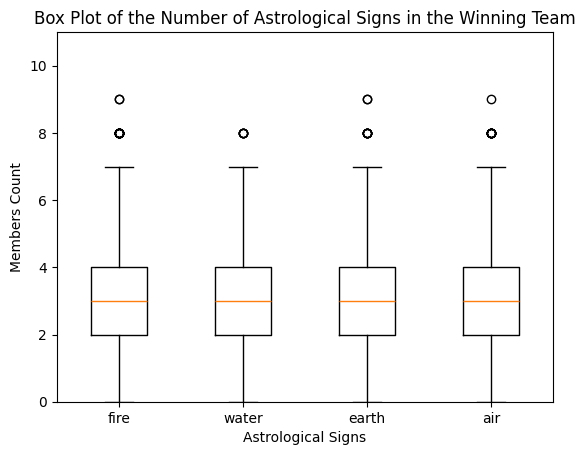

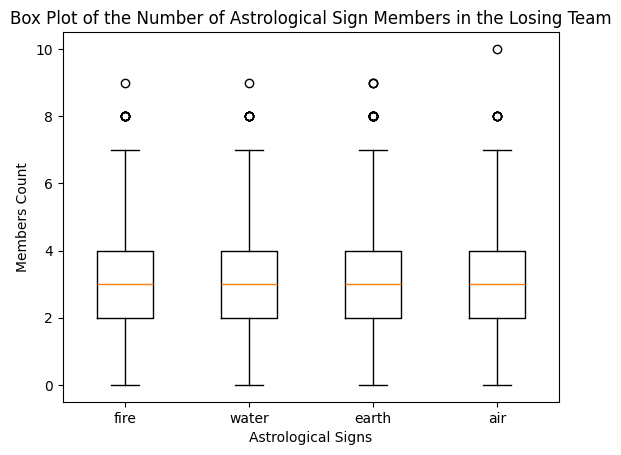

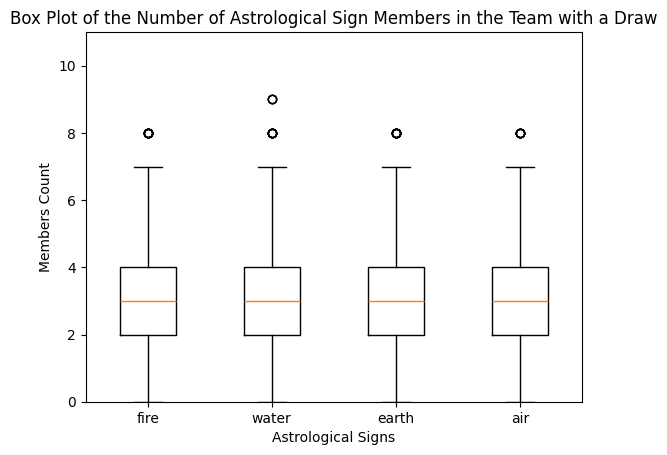

In [15]:
# 盒鬚圖
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('win_lose_signs.csv')

# 贏的隊伍四象人數圖
plt.boxplot([df[df['status'] == 'win']['fire'], df[df['status'] == 'win']['water'],df[df['status'] == 'win']['earth'], df[df['status'] == 'win']['air']],
            labels=['fire', 'water', 'earth', 'air'])
plt.xlabel('Astrological Signs')
plt.ylabel('Members Count')
plt.ylim(0, 11)
plt.title('Box Plot of the Number of Astrological Signs in the Winning Team')
plt.show()

# 輸的隊伍四象人數圖
plt.boxplot([df[df['status'] == 'lose']['fire'], df[df['status'] == 'lose']['water'],df[df['status'] == 'lose']['earth'], df[df['status'] == 'lose']['air']],
            labels=['fire', 'water', 'earth', 'air'], )
plt.xlabel('Astrological Signs')
plt.ylabel('Members Count')
plt.title('Box Plot of the Number of Astrological Sign Members in the Losing Team')
plt.show()

# 平局的隊伍四象人數圖
plt.boxplot([df[df['status'] == 'a draw']['fire'], df[df['status'] == 'a draw']['water'],df[df['status'] == 'a draw']['earth'], df[df['status'] == 'a draw']['air']],
            labels=['fire', 'water', 'earth', 'air'])
plt.xlabel('Astrological Signs')
plt.ylabel('Members Count')
plt.ylim(0, 11)
plt.title('Box Plot of the Number of Astrological Sign Members in the Team with a Draw')
plt.show()

<font size=6>勝負 - 星座 盒鬚圖</font>

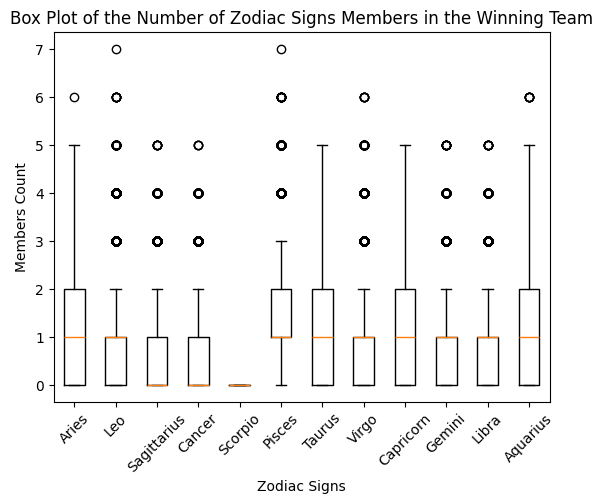

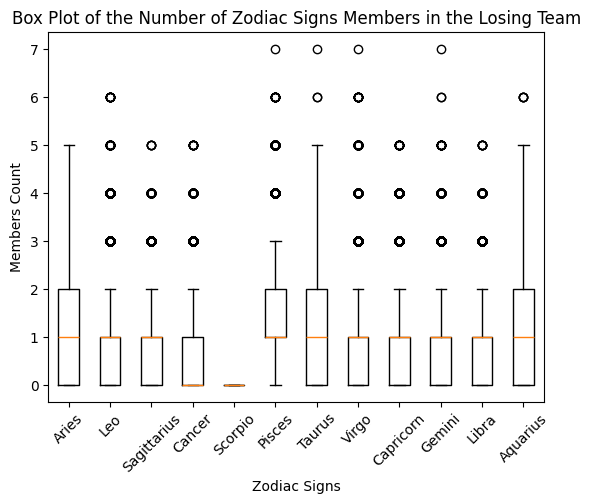

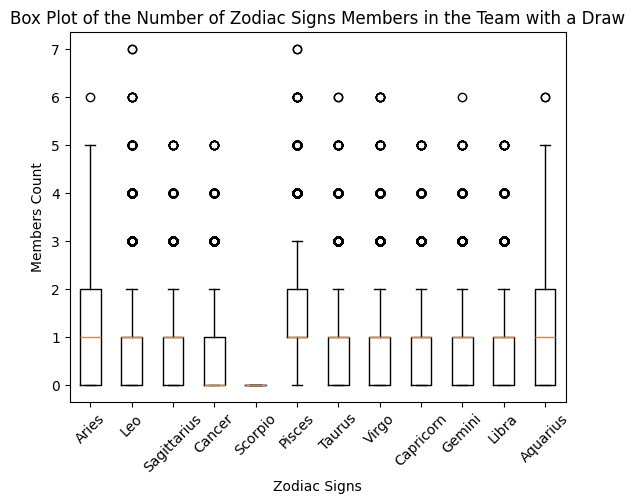

In [78]:
# 勝負平人數盒鬚圖
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv('win_lose_signs.csv')

# 贏的隊伍12星座人數圖
plt.boxplot([df[df['status'] == 'win']['Aries'], df[df['status'] == 'win']['Leo'], df[df['status'] == 'win']['Sagittarius'], 
            df[df['status'] == 'win']['Cancer'], df[df['status'] == 'win']['Scorpio'], df[df['status'] == 'win']['Pisces'],
            df[df['status'] == 'win']['Taurus'], df[df['status'] == 'win']['Virgo'], df[df['status'] == 'win']['Capricorn'],
            df[df['status'] == 'win']['Gemini'], df[df['status'] == 'win']['Libra'], df[df['status'] == 'win']['Aquarius']],
            labels=['Aries', 'Leo', 'Sagittarius', 'Cancer', 'Scorpio', 'Pisces', 'Taurus', 'Virgo', 'Capricorn', 'Gemini', 'Libra', 'Aquarius'])
plt.xlabel('Zodiac Signs')
plt.xticks(rotation=45)
plt.ylabel('Members Count')
# plt.ylim(0, 11)
plt.title('Box Plot of the Number of Zodiac Signs Members in the Winning Team')
plt.show()

# 輸的隊伍12星座人數圖
plt.boxplot([df[df['status'] == 'lose']['Aries'], df[df['status'] == 'lose']['Leo'], df[df['status'] == 'lose']['Sagittarius'], 
            df[df['status'] == 'lose']['Cancer'], df[df['status'] == 'lose']['Scorpio'], df[df['status'] == 'lose']['Pisces'],
            df[df['status'] == 'lose']['Taurus'], df[df['status'] == 'lose']['Virgo'], df[df['status'] == 'lose']['Capricorn'],
            df[df['status'] == 'lose']['Gemini'], df[df['status'] == 'lose']['Libra'], df[df['status'] == 'lose']['Aquarius']],
            labels=['Aries', 'Leo', 'Sagittarius', 'Cancer', 'Scorpio', 'Pisces', 'Taurus', 'Virgo', 'Capricorn', 'Gemini', 'Libra', 'Aquarius'])
plt.xlabel('Zodiac Signs')
plt.ylabel('Members Count')
plt.xticks(rotation=45)
# plt.ylim(0, 11)
plt.title('Box Plot of the Number of Zodiac Signs Members in the Losing Team')
plt.show()

# 平手的隊伍12星座人數圖
plt.boxplot([df[df['status'] == 'a draw']['Aries'], df[df['status'] == 'a draw']['Leo'], df[df['status'] == 'a draw']['Sagittarius'], 
            df[df['status'] == 'a draw']['Cancer'], df[df['status'] == 'a draw']['Scorpio'], df[df['status'] == 'a draw']['Pisces'],
            df[df['status'] == 'a draw']['Taurus'], df[df['status'] == 'a draw']['Virgo'], df[df['status'] == 'a draw']['Capricorn'],
            df[df['status'] == 'a draw']['Gemini'], df[df['status'] == 'a draw']['Libra'], df[df['status'] == 'a draw']['Aquarius']],
            labels=['Aries', 'Leo', 'Sagittarius', 'Cancer', 'Scorpio', 'Pisces', 'Taurus', 'Virgo', 'Capricorn', 'Gemini', 'Libra', 'Aquarius'])
plt.xlabel('Zodiac Signs')
plt.ylabel('Members Count')
plt.xticks(rotation=45)
# plt.ylim(0, 11)
plt.title('Box Plot of the Number of Zodiac Signs Members in the Team with a Draw')
plt.show()

<font size=6>勝負 - 星座人數差 盒鬚圖</font>

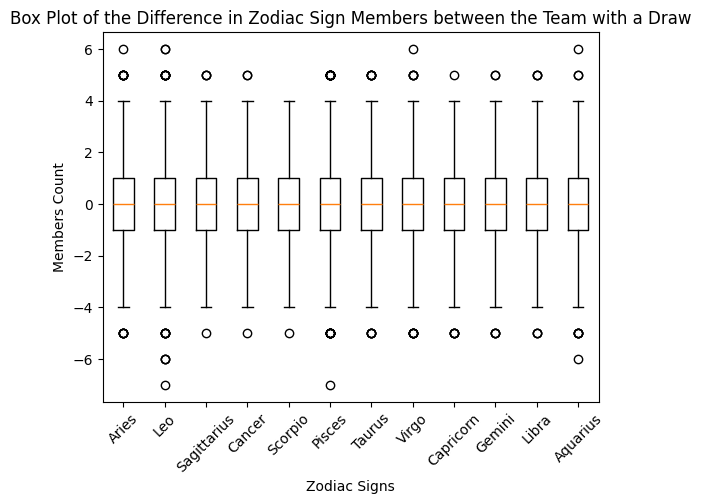

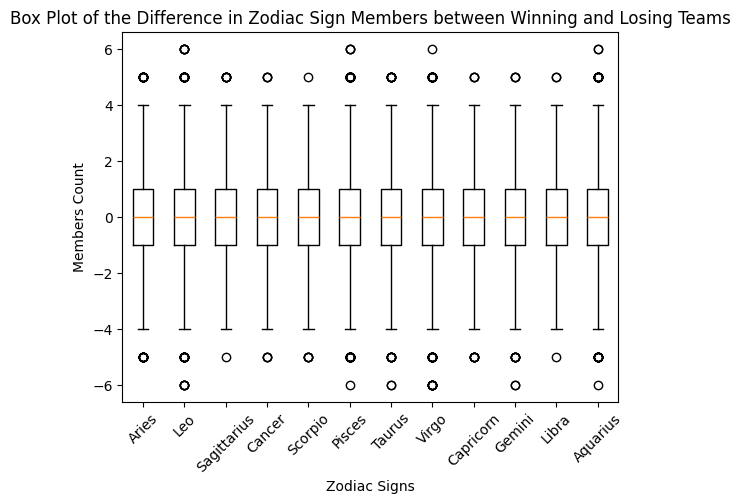

In [18]:
# 計算人數差跟繪圖
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 12星座
# 平局人數差盒鬚圖
plt.boxplot([difference_df[difference_df['status'] == 'a draw']['Aries'], 
             difference_df[difference_df['status'] == 'a draw']['Leo'], 
             difference_df[difference_df['status'] == 'a draw']['Sagittarius'], 
             difference_df[difference_df['status'] == 'a draw']['Cancer'], 
             difference_df[difference_df['status'] == 'a draw']['Scopio'], 
             difference_df[difference_df['status'] == 'a draw']['Pisces'],
             difference_df[difference_df['status'] == 'a draw']['Taurus'], 
             difference_df[difference_df['status'] == 'a draw']['Virgo'], 
             difference_df[difference_df['status'] == 'a draw']['Capricorn'],
             difference_df[difference_df['status'] == 'a draw']['Gemini'], 
             difference_df[difference_df['status'] == 'a draw']['Libra'], 
             difference_df[difference_df['status'] == 'a draw']['Aquarius']],
            labels=['Aries', 'Leo', 'Sagittarius', 'Cancer', 'Scorpio', 'Pisces', 'Taurus', 'Virgo', 'Capricorn', 'Gemini', 'Libra', 'Aquarius'])
plt.xlabel('Zodiac Signs')
plt.ylabel('Members Count')
plt.xticks(rotation=45)
plt.title('Box Plot of the Difference in Zodiac Sign Members between the Team with a Draw')
plt.show()

# 勝負局人數差盒鬚圖
plt.boxplot([difference_df[difference_df['status'] == 'win']['Aries'], 
             difference_df[difference_df['status'] == 'win']['Leo'], 
             difference_df[difference_df['status'] == 'win']['Sagittarius'], 
             difference_df[difference_df['status'] == 'win']['Cancer'], 
             difference_df[difference_df['status'] == 'win']['Scopio'], 
             difference_df[difference_df['status'] == 'win']['Pisces'],
             difference_df[difference_df['status'] == 'win']['Taurus'], 
             difference_df[difference_df['status'] == 'win']['Virgo'], 
             difference_df[difference_df['status'] == 'win']['Capricorn'],
             difference_df[difference_df['status'] == 'win']['Gemini'], 
             difference_df[difference_df['status'] == 'win']['Libra'], 
             difference_df[difference_df['status'] == 'win']['Aquarius']],
            labels=['Aries', 'Leo', 'Sagittarius', 'Cancer', 'Scorpio', 'Pisces', 'Taurus', 'Virgo', 'Capricorn', 'Gemini', 'Libra', 'Aquarius'])
plt.xlabel('Zodiac Signs')
plt.ylabel('Members Count')
plt.xticks(rotation=45)
plt.title('Box Plot of the Difference in Zodiac Sign Members between Winning and Losing Teams')
plt.show()


<font size=6>勝負 - 星象人數差 盒鬚圖</font>

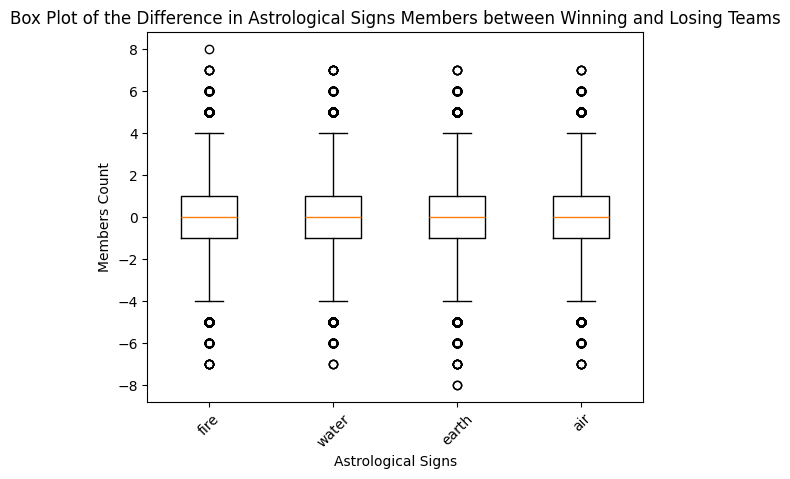

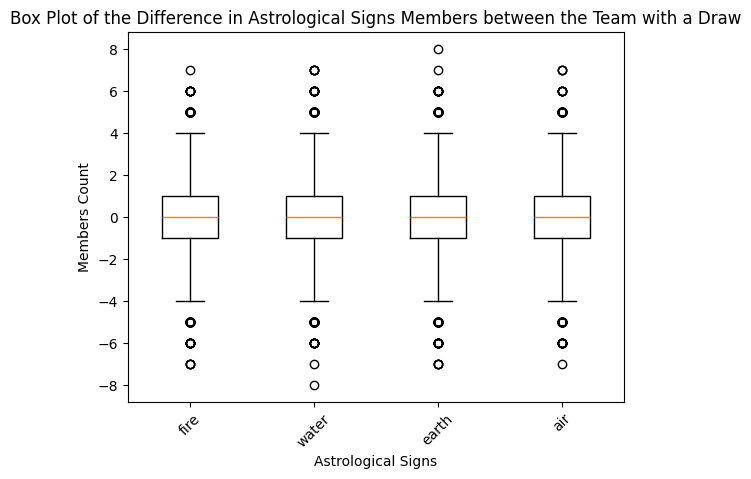

In [19]:
# 四象人數差盒鬚圖
# 勝局四象人數差盒鬚圖
plt.boxplot([difference_df[difference_df['status'] == 'win']['fire'], 
             difference_df[difference_df['status'] == 'win']['water'],
             difference_df[difference_df['status'] == 'win']['earth'], 
             difference_df[difference_df['status'] == 'win']['air']],
            labels=['fire', 'water', 'earth', 'air'])
plt.xlabel('Astrological Signs')
plt.ylabel('Members Count')
plt.xticks(rotation=45)
plt.title('Box Plot of the Difference in Astrological Signs Members between Winning and Losing Teams')
plt.show()

# 平局四象人數差盒鬚圖
plt.boxplot([difference_df[difference_df['status'] == 'a draw']['fire'], 
             difference_df[difference_df['status'] == 'a draw']['water'],
             difference_df[difference_df['status'] == 'a draw']['earth'], 
             difference_df[difference_df['status'] == 'a draw']['air']],
            labels=['fire', 'water', 'earth', 'air'])
plt.xlabel('Astrological Signs')
plt.ylabel('Members Count')
plt.xticks(rotation=45)
plt.title('Box Plot of the Difference in Astrological Signs Members between the Team with a Draw')
plt.show()

<font size=7>星象與比賽結果獨立性檢定</font>

In [23]:
# 獨立性檢定 看星象跟比賽結果的關係
import pandas as pd
from scipy.stats import chi2_contingency
df = pd.read_csv('win_lose_signs.csv')

# 將資料依勝負平分開
df_win = df[df['status'] == 'win']
df_lose = df[df['status'] == 'lose']
df_draw = df[df['status'] == 'a draw']

# 計算火象三情況的發生次數
total_win_fire = df_win['fire'].sum()
total_lose_fire = df_lose['fire'].sum()
total_draw_fire = df_draw['fire'].sum()

# 計算水象三情況的發生次數
total_win_water = df_win['water'].sum()
total_lose_water = df_lose['water'].sum()
total_draw_water = df_draw['water'].sum()

# 計算土象三情況的發生次數
total_win_earth = df_win['earth'].sum()
total_lose_earth = df_lose['earth'].sum()
total_draw_earth = df_draw['earth'].sum()

# 計算風象三情況的發生次數
total_win_air = df_win['air'].sum()
total_lose_air = df_lose['air'].sum()
total_draw_air = df_draw['air'].sum()


# 紀錄各情況的次數
observed_frequencies = {
    'fire': [total_win_fire, total_draw_fire, total_lose_fire],
    'water': [44012, 30028, 44279],
    'earth': [total_win_earth, total_draw_earth, total_lose_earth],
    'air': [total_win_air, total_draw_air, total_lose_air]
}

# 建立列聯表
df = pd.DataFrame(observed_frequencies, index=['win', 'a draw', 'lose'])
print(df, '\n')

# -------------------------------------------------------------------
# 創建星座和比賽結果的觀察頻率矩陣
observed_frequencies = pd.DataFrame({
    'fire': [42670, 28961, 42819],
    'water': [44012, 30028, 44279],
    'earth': [45296, 30074, 44494],
    'air': [43758, 29693, 44144]
}, index=['win', 'a draw', 'lose'])

# 執行卡方獨立性檢定
chi2, p, dof, expected = chi2_contingency(observed_frequencies)

# 顯示卡方統計值和p值
print(f"卡方統計值: {chi2}")
print(f"p值: {p}")

# 判斷結果
alpha = 0.05  # 顯著性水準
if p < alpha:
    print("拒絕虛無假設：星象與比賽結果不獨立")
else:
    print("接受虛無假設：星象與比賽結果獨立")


         fire  water  earth    air
win     42670  44012  45296  43758
a draw  28961  30028  30074  29693
lose    42819  44279  44494  44144 

卡方統計值: 12.777954662125023
p值: 0.04670072823707883
拒絕虛無假設：星象與比賽結果不獨立


In [26]:
# 獨立性檢定 看星"座"跟比賽結果的關係
import pandas as pd
from scipy.stats import chi2_contingency
df = pd.read_csv('win_lose_signs.csv')

# 將資料依勝負平分開
df_win = df[df['status'] == 'win']
df_lose = df[df['status'] == 'lose']
df_draw = df[df['status'] == 'a draw']

# 計算12星座三情況的發生次數
total_win_Aries = df_win['Aries'].sum()
total_lose_Aries = df_lose['Aries'].sum()
total_draw_Aries = df_draw['Aries'].sum()

total_win_Taurus = df_win['Taurus'].sum()
total_lose_Taurus = df_lose['Taurus'].sum()
total_draw_Taurus = df_draw['Taurus'].sum()

total_win_Gemini = df_win['Gemini'].sum()
total_lose_Gemini = df_lose['Gemini'].sum()
total_draw_Gemini = df_draw['Gemini'].sum()

total_win_Cancer = df_win['Cancer'].sum()
total_lose_Cancer = df_lose['Cancer'].sum()
total_draw_Cancer = df_draw['Cancer'].sum()

total_win_Leo = df_win['Leo'].sum()
total_lose_Leo = df_lose['Leo'].sum()
total_draw_Leo = df_draw['Leo'].sum()

total_win_Virgo = df_win['Virgo'].sum()
total_lose_Virgo = df_lose['Virgo'].sum()
total_draw_Virgo = df_draw['Virgo'].sum()

total_win_Libra = df_win['Libra'].sum()
total_lose_Libra = df_lose['Libra'].sum()
total_draw_Libra = df_draw['Libra'].sum()

total_win_Scorpio = df_win['Scopio'].sum()
total_lose_Scorpio = df_lose['Scopio'].sum()
total_draw_Scorpio = df_draw['Scopio'].sum()

total_win_Sagittarius = df_win['Sagittarius'].sum()
total_lose_Sagittarius = df_lose['Sagittarius'].sum()
total_draw_Sagittarius = df_draw['Sagittarius'].sum()

total_win_Capricorn = df_win['Capricorn'].sum()
total_lose_Capricorn = df_lose['Capricorn'].sum()
total_draw_Capricorn = df_draw['Capricorn'].sum()

total_win_Aquarius = df_win['Aquarius'].sum()
total_lose_Aquarius = df_lose['Aquarius'].sum()
total_draw_Aquarius = df_draw['Aquarius'].sum()

total_win_Pisces = df_win['Pisces'].sum()
total_lose_Pisces = df_lose['Pisces'].sum()
total_draw_Pisces = df_draw['Pisces'].sum()

observed_frequencies = {
    'Aries': [total_win_Aries, total_draw_Aries, total_lose_Aries],
    'Taurus': [total_win_Taurus, total_draw_Taurus, total_lose_Taurus],
    'Gemini': [total_win_Gemini, total_draw_Gemini, total_lose_Gemini],
    'Cancer': [total_win_Cancer, total_draw_Cancer, total_lose_Cancer],
    'Leo': [total_win_Leo, total_draw_Leo, total_lose_Leo],
    'Virgo': [total_win_Virgo, total_draw_Virgo, total_lose_Virgo],
    'Libra': [total_win_Libra, total_draw_Libra, total_lose_Libra],
    'Scorpio': [10987, 7394, 11304],
    'Sagittarius': [total_win_Sagittarius, total_draw_Sagittarius, total_lose_Sagittarius],
    'Capricorn': [total_win_Capricorn, total_draw_Capricorn, total_lose_Capricorn],
    'Aquarius': [total_win_Aquarius, total_draw_Aquarius, total_lose_Aquarius],
    'Pisces': [total_win_Pisces, total_draw_Pisces, total_lose_Pisces],
}

# 建立列聯表
df = pd.DataFrame(observed_frequencies, index=['win', 'a draw', 'lose'])
print(df, '\n')

# -------------------------------------------------------------------
# 創建星座和比賽結果的觀察頻率矩陣
observed_frequencies = pd.DataFrame({
    'Aries': [16648, 11028, 16566],
    'Taurus': [15535, 10351, 15331],
    'Gemini': [14228, 9635, 14354],
    'Cancer': [10481, 7140, 10221],
    'Leo': [14761, 10193, 14923],
    'Virgo': [14482, 9608, 14252],
    'Libra': [11678, 8292, 12333],
    'Scorpio': [10987, 7394, 11304],
    'Sagittarius': [11261, 7740, 11330],
    'Capricorn': [15279, 10115, 14911],
    'Aquarius': [17852, 11766, 17457],
    'Pisces': [22544, 15494, 22754]
}, index=['win', 'a draw', 'lose'])

# 執行卡方獨立性檢定
chi2, p, dof, expected = chi2_contingency(observed_frequencies)

# 顯示卡方統計值和p值
print(f"卡方統計值: {chi2}")
print(f"p值: {p}")

# 判斷結果
alpha = 0.05  # 顯著性水準
if p < alpha:
    print("拒絕虛無假設：星座與比賽結果不獨立")
else:
    print("接受虛無假設：星座與比賽結果獨立")

        Aries  Taurus  Gemini  Cancer    Leo  Virgo  Libra  Scorpio  \
win     16648   15535   14228   10481  14761  14482  11678    10987   
a draw  11028   10351    9635    7140  10193   9608   8292     7394   
lose    16566   15331   14354   10221  14923  14252  12333    11304   

        Sagittarius  Capricorn  Aquarius  Pisces  
win           11261      15279     17852   22544  
a draw         7740      10115     11766   15494  
lose          11330      14911     17457   22754   

卡方統計值: 58.412803954560395
p值: 3.825518173332534e-05
拒絕虛無假設：星座與比賽結果不獨立


<font size=7>繪製星座與星象三情況分布stack bar chart</font>

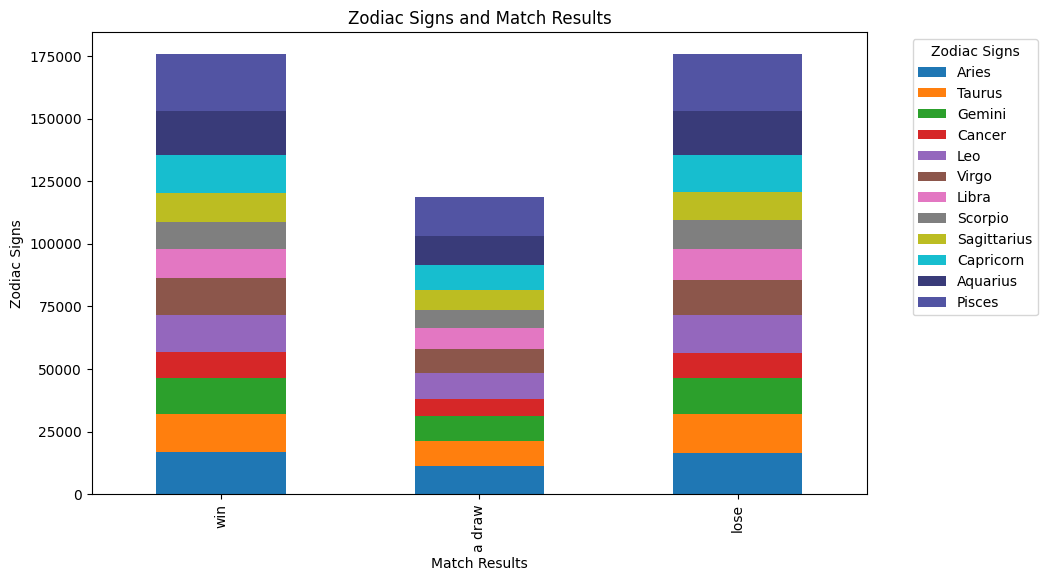

In [ ]:
# 星座在三情況stack bar chart
# stack bar chart
import pandas as pd
import matplotlib.pyplot as plt

# 輸入觀察頻率的數據
observed_frequencies = pd.DataFrame({
    'Aries': [16648, 11028, 16566],
    'Taurus': [15535, 10351, 15331],
    'Gemini': [14228, 9635, 14354],
    'Cancer': [10481, 7140, 10221],
    'Leo': [14761, 10193, 14923],
    'Virgo': [14482, 9608, 14252],
    'Libra': [11678, 8292, 12333],
    'Scorpio': [10987, 7394, 11304],
    'Sagittarius': [11261, 7740, 11330],
    'Capricorn': [15279, 10115, 14911],
    'Aquarius': [17852, 11766, 17457],
    'Pisces': [22544, 15494, 22754]
}, index=['win', 'a draw', 'lose'])

# 自定義顏色列表，請確保列表長度等於星座的數量
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#393b79', '#5254a3']

# 製作堆疊條形圖並指定顏色
ax = observed_frequencies.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# 設置圖表標籤
plt.title('Zodiac Signs and Match Results')
plt.xlabel('Match Results')
plt.ylabel('Zodiac Signs')

# 顯示圖例
plt.legend(title='Zodiac Signs', bbox_to_anchor=(1.05, 1), loc='upper left')

# 顯示圖表
plt.show()

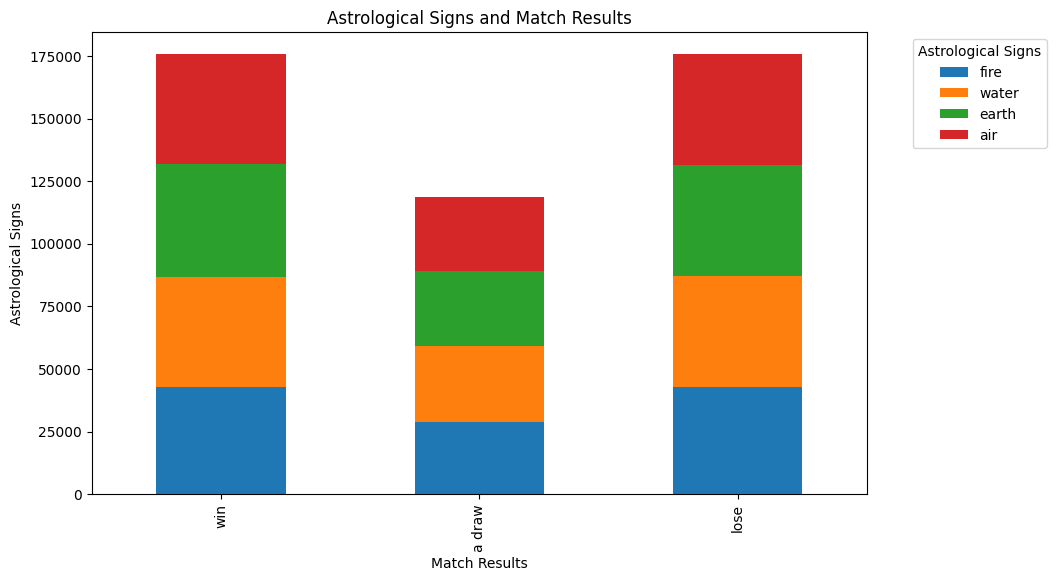

In [27]:
# 星象在三情況stack bar chart
import pandas as pd
import matplotlib.pyplot as plt

# 輸入觀察頻率的數據
observed_frequencies = pd.DataFrame({
    'fire': [42670, 28961, 42819],
    'water': [44012, 30028, 44279],
    'earth': [45296, 30074, 44494],
    'air': [43758, 29693, 44144]
}, index=['win', 'a draw', 'lose'])

# 製作堆疊條形圖
ax = observed_frequencies.plot(kind='bar', stacked=True, figsize=(10, 6))

# 設置圖表標籤
plt.title('Astrological Signs and Match Results')
plt.xlabel('Match Results')
plt.ylabel('Astrological Signs')

# 顯示圖例
plt.legend(title='Astrological Signs', bbox_to_anchor=(1.05, 1), loc='upper left')

# 顯示圖表
plt.show()